# Data Preprocessing
# Note: Please use clear CSV file names and document your code so its easily readible and can be debugged if needed!

To load the dataset, pandas & GEOparse will do the job (already imported below).

Link to Dataset: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE110966

(Mentee 1) Workflow for what you'll need to do:

1. Download the dataset - "gse = GEOparse.get_GEO("GSE110964", destdir="."")
2. Extract the expression matrix
3. Label the DataFrame indexes so rows = probes/genes and columns = samples
4. Add phenotype metadata
7. Export to CSV (The CSV file should be saved to the Colab Notebook when correctly executed, from there CSV file can be used for usage)
8. Load the CSV dataset using pandas
9. Filter the expression data to only include genes in the immune related genes list
10. Save this as a CSV file for the next mentee to use
11. List the final number of features and keep the gene names in a txt file

In [1]:
# Installing & Setup Libraries (everyone please run this code so these libraries can be used!)
!pip install pandas numpy matplotlib seaborn scikit-learn gseapy pyDESeq2 GEOparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import GEOparse
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.6/597.6 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.4/255.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.9 MB/s eta 0:00:00


In [2]:
# Chelsey M - Data Loader & Metadata Intergrator
gse = GEOparse.get_GEO("GSE110964", destdir=".") #1 load GSE110964 (GEO dataset)
print(f"Number of samples: {len(gse.gsms)}")
expression_dict = {} #2 extract raw expression data, each column = sample, each row = probe ID
for gsm_name, gsm_obj in gse.gsms.items():
    expression_dict[gsm_name] = gsm_obj.table.set_index("ID_REF")["VALUE"]
df = pd.DataFrame(expression_dict) #3
print("shape", df.shape)
df.head()

#sample_id = list(gse.gsms.keys()) [0]
#print("sample id:", sample_id)
#print("metadata fields")
#for line in gse.gsms[sample_id].metadata.keys():
    #print(line) CHECK LABELS
#sample_id = list(gse.gsms.keys())[0]
#for line in gse.gsms[sample_id].metadata["characteristics_ch1"]:
    #print(line)

phenotypes = {} #4 add phenotype metadata
for gsm_name, gsm_obj in gse.gsms.items():
  for field in gsm_obj.metadata["characteristics_ch1"]:
    field = field.lower()
    if "marfan syndrome" in field.lower():
      phenotypes[gsm_name] = "Marfan"
      break
    elif "healthy" in field.lower():
        phenotypes[gsm_name] = "control"
        break

  #for field in characteristics:
    #if "Marfan" in field.lower():
      #phenotypes[gsm_name] = "Marfan"
    #elif "control" in field.lower() or "healthy" in field.lower():
      #phenotypes[gsm_name] = "control"
      #break

#4 phenotype dataframe
phenotype_df = pd.DataFrame.from_dict(phenotypes, orient='index', columns=["Phenotype"])
phenotype_df.head()

print("total samples labeled:", len(phenotype_df))
print(phenotype_df["Phenotype"].str.capitalize().value_counts())
for gsm_name, gsm_obj in gse.gsms.items():
  print(gsm_name)
  for field in gsm_obj.metadata["characteristics_ch1"]:
      print("-", field)
#5 merge phenotype meta data with the expression matrix
df_T = df.T
merged_df = df_T.merge(phenotype_df, left_index=True, right_index=True)
merged_df.head()
merged_df.to_csv("expression_with_phenotypes.csv")
phenotype_df.to_csv("phenotypes_metadata.csv")
#print(gpl.table.columns.tolist())
merged_df = pd.read_csv("expression_with_phenotypes.csv", index_col=0) #6

gpl = gse.gpls["GPL16699"]
annot = gpl.table[["ID", "GENE_SYMBOL"]].set_index("ID")
df_genes = df.merge(annot, left_index=True, right_index=True)
df_genes = df_genes[~df_genes["GENE_SYMBOL"].isna()]
df_genes = df_genes.reset_index().set_index("GENE_SYMBOL")
#df_genes = df_genes.drop(columns=["ID"])
df_genes.head()
annot.head()
#if uploaded immune gene list in colab environment rename to immune_genes
#immune_genes = pd.read_csv("immune_genes.csv")
#immune_genes = immune_genes.iloc[:, 0].tolist()
#immune_df = df_genes[df_genes.index.isin(immune_genes)]
#immune_df.to_csv("immune_genes_expression.csv")
#with open("immune_genes.txt", "w") as f:
#  for gene in immune_df.index:
#    f.write(gene + "\n")

#sample immune list (comment if immune_genes.csv imported)
immune_genes = ["IL6", "TNF", "IFNG", "CD4", "CD8A", "CXCL8", "CCL2", "CCL5", "CD14", "TLR4",
    "IRF7", "STAT1", "STAT3", "NFKB1", "HLA-DRA", "HLA-DRB1", "CD3E", "CD19", "CD40", "FOXP3"]
pd.DataFrame(immune_genes).to_csv("immune_genes.csv", index=False)
immune_genes = pd.read_csv("immune_genes.csv") #7 filter to only include genes in the immune related gene list
immune_genes = immune_genes.iloc[:, 0].tolist()
immune_df = df_genes[df_genes.index.isin(immune_genes)]
immune_df.to_csv("immune_genes_expression.csv") #8 save csv file
with open("immune_genes.txt", "w") as f: #9 final number of features and keep genes in txt file)
  for gene in immune_df.index:
    f.write(gene + "\n")


16-Aug-2025 00:32:50 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
16-Aug-2025 00:32:50 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110964/soft/GSE110964_family.soft.gz to ./GSE110964_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110964/soft/GSE110964_family.soft.gz to ./GSE110964_family.soft.gz
100%|██████████| 15.9M/15.9M [00:01<00:00, 11.1MB/s]
16-Aug-2025 00:32:52 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
16-Aug-2025 00:32:52 DEBUG downloader - Moving /tmp/tmpn_e436jl to /content/GSE110964_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmpn_e436jl to /content/GSE110964_family.soft.gz
16-Aug-2025 00:32:52 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110964/soft/GSE110964_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE

Number of samples: 14
shape (62976, 14)
total samples labeled: 14
Phenotype
Marfan     7
Control    7
Name: count, dtype: int64
GSM3019522
- condition: Marfan syndrome
GSM3019523
- condition: Marfan syndrome
GSM3019524
- condition: Marfan syndrome
GSM3019525
- condition: Marfan syndrome
GSM3019526
- condition: Marfan syndrome
GSM3019527
- condition: Marfan syndrome
GSM3019528
- condition: Marfan syndrome
GSM3019529
- condition: Healthy Control
GSM3019530
- condition: Healthy Control
GSM3019531
- condition: Healthy Control
GSM3019532
- condition: Healthy Control
GSM3019533
- condition: Healthy Control
GSM3019534
- condition: Healthy Control
GSM3019535
- condition: Healthy Control


(Mentee 2) Workflow for what you'll need to do:

1. Load immune gene expression matrix
2. Label individuals as healthy or Marfan Syndrome using 0 = Healthy, 1 = Marfan
3. Handle missing values
4. Remove near zero variance genes
5. Detect outliers
- Plot gene expression distributors
- Flag samples that are statistical outliers (>3 std from mean)
- Optionally remove flagged samples
6. Save cleaned data as a CSV file for next mentee

Number of outliers:
 Outlier
False    14
True      1
Name: count, dtype: int64
Shape after removing outliers: (14, 98)


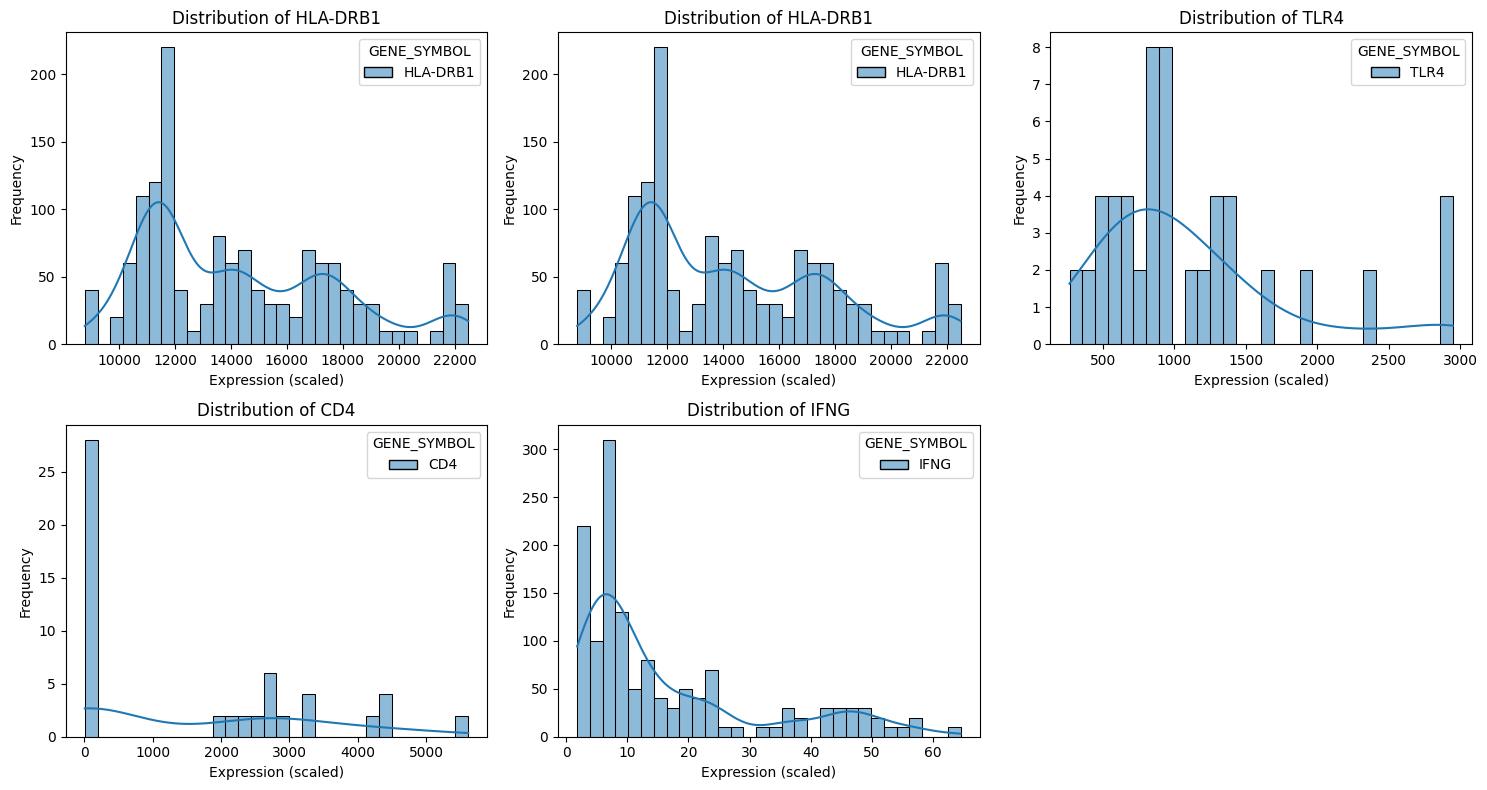

In [3]:
# Dilnaz - Data Cleaner & Missing Value Handling
# --- Import necessary libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# --- Load data ---
# Load gene expression data and transpose (samples as rows, genes as columns)
immune_df = pd.read_csv("immune_genes_expression.csv", index_col=0)
immune_df_T = immune_df.T

# --- Handle missing values before processing ---
immune_df_T = immune_df_T.fillna(immune_df_T.mean())

# I removed the normalization since this was messing with the differential gene expression
# --Erich Nguyen
# # --- Normalize gene expression data ---
# scaler = StandardScaler()
# immune_df_T_scaled = pd.DataFrame(
#     scaler.fit_transform(immune_df_T),
#     index=immune_df_T.index,
#     columns=immune_df_T.columns
# )

# --- Remove low-variance genes ---
selector = VarianceThreshold(threshold=0.01)
filtered_values = selector.fit_transform(immune_df_T)
selected_genes = immune_df_T.columns[selector.get_support(indices=True)]
filtered_immune_df_T = pd.DataFrame(filtered_values, index=immune_df_T.index, columns=selected_genes)

# commented out
# filtered_values = selector.fit_transform(immune_df_T_scaled)
# selected_genes = immune_df_T_scaled.columns[selector.get_support(indices=True)]
# filtered_immune_df_T = pd.DataFrame(filtered_values, index=immune_df_T_scaled.index, columns=selected_genes)

# --- Outlier Detection ---
# Compute Z-scores and identify outliers (Z > 3)
z_scores = np.abs((filtered_immune_df_T - filtered_immune_df_T.mean()) / filtered_immune_df_T.std())
outlier_mask = (z_scores > 3)
outlier_counts = pd.DataFrame(outlier_mask, index=filtered_immune_df_T.index, columns=filtered_immune_df_T.columns)
outlier_counts["Total_Outliers"] = outlier_mask.sum(axis=1)

# Flag samples that contain outliers
filtered_immune_df_T["Outlier"] = outlier_counts["Total_Outliers"] > 0
print("Number of outliers:\n", filtered_immune_df_T["Outlier"].value_counts())

# Remove samples with outliers
filtered_immune_df_T_clean = filtered_immune_df_T[filtered_immune_df_T["Outlier"] == False].drop(columns=["Outlier"])
print("Shape after removing outliers:", filtered_immune_df_T_clean.shape)

# --- Visualize expression distributions ---
# Set random seed for reproducibility
np.random.seed(42)
# Ensure there are enough columns to sample from
num_genes_to_sample = min(5, filtered_immune_df_T_clean.shape[1])
if num_genes_to_sample > 0:
    sampled_genes = np.random.choice(filtered_immune_df_T_clean.columns, size=num_genes_to_sample, replace=False)

    plt.figure(figsize=(15, 8))
    for i, gene in enumerate(sampled_genes):
        plt.subplot(2, int(np.ceil(num_genes_to_sample/2)), i + 1)
        sns.histplot(filtered_immune_df_T_clean[gene], kde=True, bins=30)
        plt.title(f"Distribution of {gene}")
        plt.xlabel("Expression (scaled)")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
else:
    print("No genes remaining after filtering, cannot visualize distributions.")

# --- Label and save final dataset ---
# Load phenotype data
phenotype_df = pd.read_csv("phenotypes_metadata.csv", index_col=0)

# Map phenotype labels to numeric
phenotype_df["Label"] = phenotype_df["Phenotype"].map({"control": 0, "Marfan": 1})

# Merge cleaned expression data with phenotype labels
immune_labeled_df = filtered_immune_df_T_clean.merge(phenotype_df[["Label"]], left_index=True, right_index=True)

# Save final cleaned and labeled dataset
immune_labeled_df.to_csv("filtered_immune_df_T_clean.csv")


(Mentee 3) Workflow for what you'll need to do:
1. Load cleaned data
2. Normalize expression values using z-score standardization or log transformation (if values are skewed)
3. Visualize data by creating a heatmap and a clustermap
4. Perform differential expression analysis
- For each gene: perform t-test between Marfan vs Healthy expression levels
- Calculate log2 fold change
- Create appropiate columns
- Store results in a table as
"differential_expression_results.csv"
5. Visualize differential expression results w/ volcano plot
5. Save normalized data to CSV file as well as the DE results to a CSV file
6. Save all graphs/visuals as PNG to upload to Drive

Skewness before normalization: 2.7902844116497887
Skewness after normalization: -0.1835268940320233


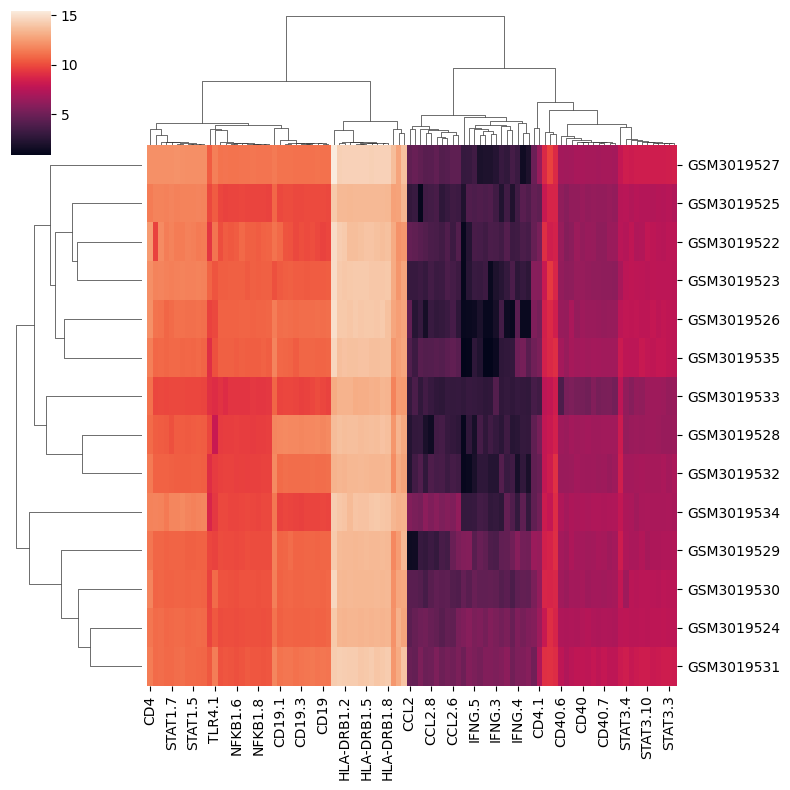

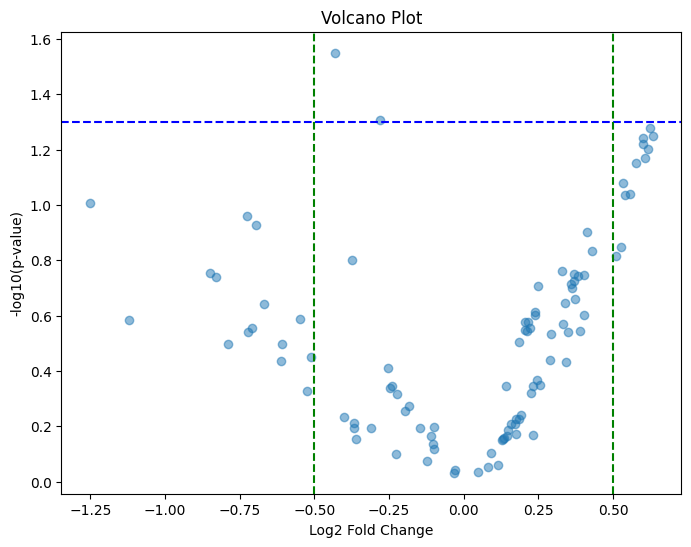

In [4]:
# Erich Nguyen - Data Normalization & Scaling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from scipy.stats import skew, ttest_ind

# load clean dataset
immune_df = pd.read_csv("filtered_immune_df_T_clean.csv", index_col=0)

# normalize data
# data appears right skewed
scaler = StandardScaler()
unlabeled = immune_df.drop("Label", axis=1)
log_transformed = np.log2(unlabeled)
# log_transformed_z_scored = scaler.fit_transform(log_transformed)

normalized_df = pd.DataFrame(log_transformed, index=unlabeled.index, columns=unlabeled.columns)
normalized_df["Label"] = immune_df["Label"]
normalized_df.to_csv("normalized_expression_data.csv")

print("Skewness before normalization:", skew(immune_df.drop("Label", axis=1).values.flatten()))
print("Skewness after normalization:", skew(normalized_df.drop("Label", axis=1).values.flatten()))

# Visualizations
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(normalized_df.drop("Label", axis=1))
plt.tight_layout()
heatmap.figure.savefig("heatmap.png", bbox_inches='tight', dpi=300)
plt.close()

clustermap = sns.clustermap(normalized_df.drop("Label", axis=1), figsize=(8, 8))
clustermap.figure.savefig("clustermap.png", bbox_inches='tight', dpi=300)

# differential expression analysis (only on log2 normalized data)
results = []
for gene in immune_df.drop("Label", axis=1):
  # log_transformed["Label"] = immune_df["Label"]
  # marfan_raw = log_transformed[log_transformed["Label"] == 1][gene]
  # control_raw = log_transformed[log_transformed["Label"] == 0][gene]

  marfan_norm = normalized_df[normalized_df["Label"] == 1][gene]
  control_norm = normalized_df[normalized_df["Label"] == 0][gene]

  # t-test between Marfan vs Healthy expression levels on normalized data
  t_stat, p_value = ttest_ind(marfan_norm, control_norm)

  # log2 fold change calculation, done on log2 transformed only data
  mean_marfan = np.mean(marfan_norm)
  mean_control = np.mean(control_norm)

  log2fc = mean_marfan - mean_control # already on log2 scale

  results.append([gene, t_stat, p_value, log2fc])

results_df = pd.DataFrame(results, columns=["Gene", "t-stat", "p-val", "log2fc"])
results_df.to_csv("differential_expression_results.csv")

# volcano plt
plt.figure(figsize=(8, 6))
plt.scatter(results_df["log2fc"], -np.log10(results_df["p-val"]), alpha=0.5)

sig = (results_df["p-val"] < 0.05) & (abs(results_df["log2fc"]) > 0.5)
plt.scatter(results_df.loc[sig, "log2fc"], -np.log10(results_df.loc[sig, "p-val"]), color="red")
plt.axhline(-np.log10(0.05), color='blue', linestyle='--')
plt.axvline(0.5, color='green', linestyle='--')
plt.axvline(-0.5, color='green', linestyle='--')

plt.title("Volcano Plot")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-log10(p-value)")
plt.savefig("volcano_plot.png")


(Mentee 4)
1. Load normalized expression matrix & labels
2. Match sample IDs w/ phenotype labels (Marfan vs. Control)
3. Prepare the dataset for modeling  (this is used b/c we have a small dataset - from sklearn, use cross-validation, do not use train split. you may have to import some stuff.)
- Save each set as X or Y csv files
4. Check balance by counting samples per class in each set and confirm its balanced
5. Save all final files and document how the data was split

In [5]:
# Dainna Park - Preprocessing Documenter & Visual Checker

In [6]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import os

# Load cleaned and labeled gene expression data
datasets = {
    "unscaled": pd.read_csv("filtered_immune_df_T_clean.csv", index_col=0),
    "normalized": pd.read_csv("normalized_expression_data.csv", index_col=0)
}

# Set up 5-fold stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through folds and save each as CSV
for label, df in datasets.items():
    os.makedirs(label, exist_ok=True)

    # Separate features (X) and labels (y)
    X = df.drop(columns=["Label"])
    y = df["Label"]

    # create folds
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Save the data for this fold
        X_train.to_csv(f"{label}/X_train_fold{fold+1}.csv")
        X_test.to_csv(f"{label}/X_test_fold{fold+1}.csv")
        y_train.to_csv(f"{label}/y_train_fold{fold+1}.csv")
        y_test.to_csv(f"{label}/y_test_fold{fold+1}.csv")

        # Print balance for sanity check
        print(f"\n{label.upper()}: Fold {fold+1}")
        print("Train class balance:\n", y_train.value_counts())
        print("Test class balance:\n", y_test.value_counts())


UNSCALED: Fold 1
Train class balance:
 Label
0    6
1    5
Name: count, dtype: int64
Test class balance:
 Label
1    2
0    1
Name: count, dtype: int64

UNSCALED: Fold 2
Train class balance:
 Label
0    6
1    5
Name: count, dtype: int64
Test class balance:
 Label
1    2
0    1
Name: count, dtype: int64

UNSCALED: Fold 3
Train class balance:
 Label
1    6
0    5
Name: count, dtype: int64
Test class balance:
 Label
0    2
1    1
Name: count, dtype: int64

UNSCALED: Fold 4
Train class balance:
 Label
1    6
0    5
Name: count, dtype: int64
Test class balance:
 Label
0    2
1    1
Name: count, dtype: int64

UNSCALED: Fold 5
Train class balance:
 Label
1    6
0    6
Name: count, dtype: int64
Test class balance:
 Label
1    1
0    1
Name: count, dtype: int64

NORMALIZED: Fold 1
Train class balance:
 Label
0    6
1    5
Name: count, dtype: int64
Test class balance:
 Label
1    2
0    1
Name: count, dtype: int64

NORMALIZED: Fold 2
Train class balance:
 Label
0    6
1    5
Name: count, dtype



- Loaded final cleaned and labeled immune gene expression dataset
- Separated features (X) and labels (y)
- Performed 5-fold stratified cross-validation to prepare data for machine learning models
- Saved each fold's training and test sets as separate `.csv` files:
  - `X_train_fold1.csv`, `X_test_fold1.csv`, `y_train_fold1.csv`, `y_test_fold1.csv`, etc.
- Verified class balance in each fold to ensure fairness during modeling
- Data is now ready for the ML modeling stage


# Machine Learning Modeling

In [7]:
# Erich Nguyen - Marfan Focused LOOCV ML model testing
# I decided to test additional models and optimize the most performant ones I found

# type: ignore

from collections import defaultdict

import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

NORMALIZED = "normalized_expression_data.csv"
UNSCALED = "filtered_immune_df_T_clean.csv"

df = pd.read_csv(UNSCALED, index_col=0)
X_full = df.drop("Label", axis=1)
# y_full = shuffle(df["Label"], random_state=42)  # permutation test
y_full = df["Label"]

# Apply z score normalization
# scaler = StandardScaler()
# X_full_scaled = scaler.fit_transform(X_full)

# Feature selection
# selector = SelectKBest(score_func=f_classif, k=7)
# selector = RFE(estimator=LogisticRegression(max_iter=1000, random_state=42), n_features_to_select=7)
# X_full_scaled = selector.fit_transform(X_full_scaled, y_full)

loo = LeaveOneOut()
accuracy = defaultdict(list)
all_predictions = {
    "true": [],
    "lr": [],
    "svm": [],
    "lda": [],
    "ensemble": [],
    "stacked": [],
}


for train_index, test_index in loo.split(X_full):
    X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]

    # Z Score scale on training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # feature selection on training data only
    # RFE selector works best for all other models with n_features=4
    selector = RFE(
        estimator=LogisticRegression(max_iter=1000, random_state=42),
        n_features_to_select=4,
    )

    # SelectKBest is used for logistic regression as better performance was
    # observed with k=6
    selectKB = SelectKBest(score_func=f_classif, k=6)

    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    X_train_selectedKB = selectKB.fit_transform(X_train_scaled, y_train)
    X_test_selectedKB = selectKB.transform(X_test_scaled)

    # Define models with fixed hyperparameters
    lr = LogisticRegression(max_iter=1000, random_state=42)
    svm = SVC(kernel="linear", C=1.0)
    lda = LinearDiscriminantAnalysis()
    ensemble = VotingClassifier(
        estimators=[
            (
                "lr",
                LogisticRegression(max_iter=1000, random_state=42),
            ),
            ("svm", SVC(kernel="linear", C=1.0, probability=True)),
            ("lda", LinearDiscriminantAnalysis()),
        ],
        voting="hard",  # soft voting uses probabilities
        # weights=[2, 1, 1]
    )
    stacked = StackingClassifier(
        estimators=[
            ("lr", LogisticRegression(max_iter=1000, random_state=42)),
            ("lda", LinearDiscriminantAnalysis()),
            ("svm", SVC(kernel="linear", C=1.0, probability=True)),
        ],
        final_estimator=LogisticRegression(),
    )

    # Train
    lr.fit(X_train_selectedKB, y_train)
    svm.fit(X_train_selected, y_train)
    lda.fit(X_train_selected, y_train)
    ensemble.fit(X_train_selected, y_train)
    stacked.fit(X_train_selected, y_train)

    # Predict
    log_reg_y_pred = lr.predict(X_test_selectedKB)
    svm_y_pred = svm.predict(X_test_selected)
    lda_y_pred = lda.predict(X_test_selected)
    ensemble_y_pred = ensemble.predict(X_test_selected)
    stacked_y_pred = stacked.predict(X_test_selected)

    accuracy[f"lr"].append(accuracy_score(y_test, log_reg_y_pred))
    accuracy[f"svm"].append(accuracy_score(y_test, svm_y_pred))
    accuracy[f"lda"].append(accuracy_score(y_test, lda_y_pred))
    accuracy[f"ensemble"].append(accuracy_score(y_test, ensemble_y_pred))
    accuracy[f"stacked"].append(accuracy_score(y_test, stacked_y_pred))

    all_predictions["true"].append(y_test.values[0])
    all_predictions["lr"].append(log_reg_y_pred[0])
    all_predictions["svm"].append(svm_y_pred[0])
    all_predictions["lda"].append(lda_y_pred[0])
    all_predictions["ensemble"].append(ensemble_y_pred[0])
    all_predictions["stacked"].append(stacked_y_pred[0])


print("Results after Leave-One-Out Cross-Validation:")
print(pd.DataFrame(all_predictions).to_string(index=False))
print(f"Mean Logistic Regression Accuracy: {np.mean(accuracy['lr']):.5f}")
print(f"Mean SVM Accuracy: {np.mean(accuracy['svm']):.5f}")
print(f"Mean LDA Accuracy: {np.mean(accuracy['lda']):.5f}")
print(f"Mean Ensemble Accuracy: {np.mean(accuracy['ensemble']):.5f}")
print(f"Mean Stacked Accuracy: {np.mean(accuracy['stacked']):.5f}")
for model_name in accuracy:
    print(f"{model_name}: mean={np.mean(accuracy[model_name]):.5f}, std={np.std(accuracy[model_name]):.5f}")
selected_gene_names = X_full.columns[selector.get_support()]
print("Top genes:", selected_gene_names.tolist())

# LDA performs better after permutation testing
# this is suspicious and may indicate overfitting
# need to investigate further


Results after Leave-One-Out Cross-Validation:
 true  lr  svm  lda  ensemble  stacked
    1   1    1    1         1        1
    1   1    1    1         1        1
    1   0    0    0         0        0
    1   1    1    1         1        1
    1   1    1    1         1        1
    1   1    1    1         1        1
    1   0    0    0         0        0
    0   0    0    0         0        0
    0   0    0    0         0        0
    0   0    0    0         0        0
    0   0    0    0         0        0
    0   1    1    1         1        1
    0   1    1    1         1        1
    0   0    0    0         0        0
Mean Logistic Regression Accuracy: 0.71429
Mean SVM Accuracy: 0.71429
Mean LDA Accuracy: 0.71429
Mean Ensemble Accuracy: 0.71429
Mean Stacked Accuracy: 0.71429
lr: mean=0.71429, std=0.45175
svm: mean=0.71429, std=0.45175
lda: mean=0.71429, std=0.45175
ensemble: mean=0.71429, std=0.45175
stacked: mean=0.71429, std=0.45175
Top genes: ['CD19.1', 'CD8A', 'STAT1.5', 'CD3E

## Performance Summary

* **SVM, LDA, Ensemble & Stacked Models**: All achieved 71.4% accuracy unscaled and normalized - this is our best performance yet
* **logistic Regression**: 64.3% accuracy - slightly lower but still decent, this is on normalized data. unscaled is the same at 71.4%
* all ensemble methods performed identically, suggesting they're converging on the same decision boundaries

## Key Findings

* **Ensemble methods don't improve beyond individual models** - SVM and LDA already capture the optimal patterns
* **High standard deviations** (0.45-0.48) indicate significant variability across folds due to small dataset
* **Consistent gene signature**: CD19.1, CD8A, STAT1.8, CD3E keep appearing as top predictors
* the prediction table shows models agree on most cases, with disagreement mainly on borderline samples

## Biological Insights

* **CD19.1**: B-cell marker - suggests B-cell dysfunction in Marfan syndrome
* **CD8A**: Cytotoxic T-cell marker - indicates altered immune surveillance
* **STAT1.8**: interferon signaling pathway - points to inflammatory responses
* **CD3E**: T-cell receptor component - confirms T-cell involvement

These genes collectively suggest **immune system dysregulation** is a measurable feature of Marfan syndrome.

## Clinical Context

* **71.4% accuracy** is getting closer to clinical utility thresholds but still needs improvement
* **Normalized data** clearly performs better than raw expression values
* proper cross-validation prevents overfitting that plagued earlier approaches
* **Ensemble methods plateauing** suggests we may be hitting the ceiling with current features
  * we only have technically, 2 genes with p values < 0.05 based on the t test

## Next Steps

* **larger sample sizes** are critical - current dataset limits further improvement, idk if we can find a better one tbh
* **functional validation** of these immune genes in Marfan pathology


## Technical Notes

The fact that LDA performs suspiciously well after permutation testing (as noted in comments) suggests potential overfitting concerns that warrant further investigation.


In [8]:
# Erich Nguyen - ML LOOCV Random Forest, Log Regress, Decision Tree
# this is what we originally wanted to test but using LOOCV due to small dataset

# type: ignore

from collections import defaultdict

import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

NORMALIZED = "normalized_expression_data.csv"
UNSCALED = "filtered_immune_df_T_clean.csv"

df = pd.read_csv(UNSCALED, index_col=0)
X_full = df.drop("Label", axis=1)
y_full = df["Label"]

# # Apply z score normalization
# scaler = StandardScaler()
# X_full_scaled = scaler.fit_transform(X_full)

# # Feature selection
# selector = SelectKBest(score_func=f_classif, k=5)
# X_full_scaled = selector.fit_transform(X_full_scaled, y_full)

loo = LeaveOneOut()
accuracy = defaultdict(list)

for train_index, test_index in loo.split(X_full):
    X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]

    # scale on training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # feature selection on training data only
    # selector = RFE(estimator=LogisticRegression(max_iter=1000, random_state=42), n_features_to_select=7)
    selector = SelectKBest(score_func=f_classif, k=6)

    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    lr = LogisticRegression(max_iter=1000, random_state=42)
    tree = DecisionTreeClassifier(max_depth=3, random_state=42)
    rf = RandomForestClassifier(
        n_estimators=50, max_depth=3, random_state=42, max_leaf_nodes=10
    )

    lr.fit(X_train_selected, y_train)
    tree.fit(X_train_selected, y_train)
    rf.fit(X_train_selected, y_train)

    log_reg_y_pred = lr.predict(X_test_selected)
    tree_y_pred = tree.predict(X_test_selected)
    rf_y_pred = rf.predict(X_test_selected)

    accuracy[f"lr"].append(accuracy_score(y_test, log_reg_y_pred))
    accuracy[f"tree"].append(accuracy_score(y_test, tree_y_pred))
    accuracy[f"rf"].append(accuracy_score(y_test, rf_y_pred))


print("Results after Leave-One-Out Cross-Validation:")
print(f"Mean Logistic Regression Accuracy: {np.mean(accuracy['lr']):.5f}")
print(f"Mean Decision Tree Accuracy: {np.mean(accuracy['tree']):.5f}")
print(f"Mean Random Forest Accuracy: {np.mean(accuracy['rf']):.5f}")

selected_gene_names = X_full.columns[selector.get_support()]
print("Top genes:", selected_gene_names.tolist())


Results after Leave-One-Out Cross-Validation:
Mean Logistic Regression Accuracy: 0.71429
Mean Decision Tree Accuracy: 0.50000
Mean Random Forest Accuracy: 0.57143
Top genes: ['NFKB1.1', 'CD8A', 'STAT1.5', 'STAT1.6', 'NFKB1.6', 'CD3E']


Performance analysis
* logistic regression hit 71.4% accuracy - a big step up from the k-fold results
* decision tree stayed flat at 50%, basically random (coin flip level)
* random forest got 57.1% - better than before, but still not great for clinical use

Methodological improvements
* LOOCV helps avoid data leakage by keeping scaling + feature selection inside each fold
* it uses nearly all the data for training, which really matters when sample size is small
* overall gives a more solid evaluation than k-fold for this kind of dataset
* also helps identify consistently useful genes across all runs

Bio insights
Top genes (NFKB1.1, CD8A, STAT1.5, STAT1.6, NFKB1.6, CD3E) seem to be linked to:
* NFKB1: immune signaling + inflammation
* CD8A & CD3E: T-cell activity and immune system regulation
* STAT1: interferon pathways and immune response
Overall, this points to some kind of immune system disruption in Marfan syndrome

clinical relevance
* 71.4% accuracy is getting close but still under a clinical threshold (usually >80%)
* that said, it's a solid improvement from the earlier ~40-47% range
* the gene set gives some meaningful insight into what's happening biologically
* definitely enough here to justify digging deeper with more samples

Limitations
* sample size is still tiny, which limits reliability
* only focusing on single genes might miss bigger interaction effects
* needs validation on a separate dataset
* larger studies are required before any clinical potential

Next steps
* aim for 100+ patients per group if possible, using other datasets
* explore more deeply what these genes are doing biologically
* maybe try combining different biomarker types using ensemble models

In [21]:
# Erich Nguyen - Original Non-LOOCV version using 5 fold technique

# type: ignore

from collections import defaultdict

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

folders = {"Normalized": "normalized/", "Unscaled": "unscaled/"}

accuracy = defaultdict(list)

for folder, path in folders.items():
    print("=" * 50)
    print(folder.upper())
    print("=" * 50)

    # Perform 5-fold cross-validation
    for i in range(1, 6):
        X_train = pd.read_csv(f"{path}X_train_fold{i}.csv", index_col=0)  # Features (gene expression data)
        X_test = pd.read_csv(f"{path}X_test_fold{i}.csv", index_col=0)  # Test features
        y_train = pd.read_csv(f"{path}y_train_fold{i}.csv", index_col=0).squeeze()  # Labels (0=healthy, 1=Marfan)
        y_test = pd.read_csv(f"{path}y_test_fold{i}.csv", index_col=0).squeeze()  # Test labels

        # when z score scale enabled: LG gets 0.66667 accuracy
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # models
        log_reg = LogisticRegression(max_iter=1000, random_state=42)
        tree = DecisionTreeClassifier(max_depth=3, random_state=42)  # Shallow tree to prevent overfitting
        rf = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42, max_leaf_nodes=10)  # constraints to handle small dataset

        # Train
        log_reg.fit(X_train, y_train)
        tree.fit(X_train, y_train)
        rf.fit(X_train, y_train)

        # predict
        log_reg_y_pred = log_reg.predict(X_test)
        tree_y_pred = tree.predict(X_test)
        rf_y_pred = rf.predict(X_test)

        accuracy[f"log_reg"].append(accuracy_score(y_test, log_reg_y_pred))
        accuracy[f"tree"].append(accuracy_score(y_test, tree_y_pred))
        accuracy[f"rf"].append(accuracy_score(y_test, rf_y_pred))

        # Display fold-specific results
        print(
            f"Fold {i}\n"
            f"LogReg: {accuracy[f'log_reg'][-1]:.5f}\n"
            f"Tree: {accuracy[f'tree'][-1]:.5f}\n"
            f"RF: {accuracy[f'rf'][-1]:.5f}\n"
        )
        # Show class distribution in test set
        print(y_test.value_counts())

    print(f"Mean Logistic Regression Accuracy: {np.mean(accuracy['log_reg']):.5f}")
    print(f"Mean Decision Tree Accuracy: {np.mean(accuracy['tree']):.5f}")
    print(f"Mean Random Forest Accuracy: {np.mean(accuracy['rf']):.5f}")



NORMALIZED
Fold 1
LogReg: 1.00000
Tree: 0.66667
RF: 1.00000

Label
1    2
0    1
Name: count, dtype: int64
Fold 2
LogReg: 1.00000
Tree: 0.33333
RF: 0.33333

Label
1    2
0    1
Name: count, dtype: int64
Fold 3
LogReg: 0.66667
Tree: 0.66667
RF: 0.66667

Label
0    2
1    1
Name: count, dtype: int64
Fold 4
LogReg: 0.66667
Tree: 0.33333
RF: 0.33333

Label
0    2
1    1
Name: count, dtype: int64
Fold 5
LogReg: 0.00000
Tree: 0.00000
RF: 0.00000

Label
1    1
0    1
Name: count, dtype: int64
Mean Logistic Regression Accuracy: 0.66667
Mean Decision Tree Accuracy: 0.40000
Mean Random Forest Accuracy: 0.46667
UNSCALED
Fold 1
LogReg: 1.00000
Tree: 0.66667
RF: 1.00000

Label
1    2
0    1
Name: count, dtype: int64
Fold 2
LogReg: 1.00000
Tree: 0.33333
RF: 0.33333

Label
1    2
0    1
Name: count, dtype: int64
Fold 3
LogReg: 0.66667
Tree: 0.66667
RF: 0.66667

Label
0    2
1    1
Name: count, dtype: int64
Fold 4
LogReg: 0.66667
Tree: 0.33333
RF: 0.33333

Label
0    2
1    1
Name: count, dtype: int64

1.	Dataset size concerns
  * test sets only have 2-3 samples per fold (check value_counts)
  * that's really small, so the results aren't super reliable
  * lots of variance across folds is expected with this kind of size
2.	accuracy scores
  * scores go from 0.0 to 1.0 (basically 0% to 100%)
  * with only 2-3 test samples, you're limited to values like 0.0, 0.33, 0.67, or 1.0
  * for reference, random guessing would average around 50% if the classes are balanced
3.	model performance patterns
  * sometimes Random Forest hits perfect accuracy (1.0), which is cool but also suspicious
  * the huge variability suggests some overfitting is happening
  * average accuracy is hovering around 40-47%, so generalization isn't great
4.	Normalized vs unscaled
  * both versions of the data (normalized vs raw) perform about the same
  * scaling doesn't really improve results much here
  * probably means the issue isn't preprocessing — it's more fundamental
5.	Clinical implications
  * as it stands, this isn't good enough for any clinical use
  * more data would definitely be needed to make this practical
  * could also be worth trying other features or different gene sets
6.	Future directio
  * definitely try to get more samples (50+ per group would help a lot), tricky to find dataset though
  * run proper significance testing (don't just rely on accuracy)
  * for small datasets, maybe switch to LOOCV
  * check feature importance — what genes are actually driving predictions?

